# Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

#### New notebook

This notebook was forked from [this](https://github.com/cdthompson/deepracer-k1999-race-lines/blob/master/Race-Line-Calculation.ipynb) notebook by cdthompson.

This repo only contains the new notebook, not the entire directory. So make sure to download the entire directory from cdthompson's repo.

In [1]:
f1='logs/line-3m0deg15a21-pathOnly-fine-evaluation-20200728010118-G8Zf3116TaGNOhhM-U55Kw-robomaker.log'
f2='logs/line-3m0deg21a21-pathOnly-fine-evaluation-20200728010134-uh1wuPtFThqLAWZEQr4NXw-robomaker.log'

In [2]:
!pip install shapely

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

## Load the track to analyze

In [4]:
# Conveniently list available tracks to analyze
#available_track_files = glob.glob("./tracks/**.npy")
available_track_names = ['reinvent_base.npy']
raceLine = []


Is loop/ring?  False


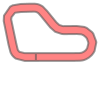

In [5]:
# Replace the name here with the track to analyze
#TRACK_NAME = 'Spain_track'
TRACK_NAME = './tracks/reinvent_base'
# Load the center, inner, outer waypoints
#waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)
waypoints = np.load("%s.npy" % TRACK_NAME)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly


Is loop/ring?  False


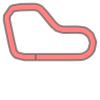

In [6]:
# Own code: Reduce width of track

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.8
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

# Display the original track waypoints

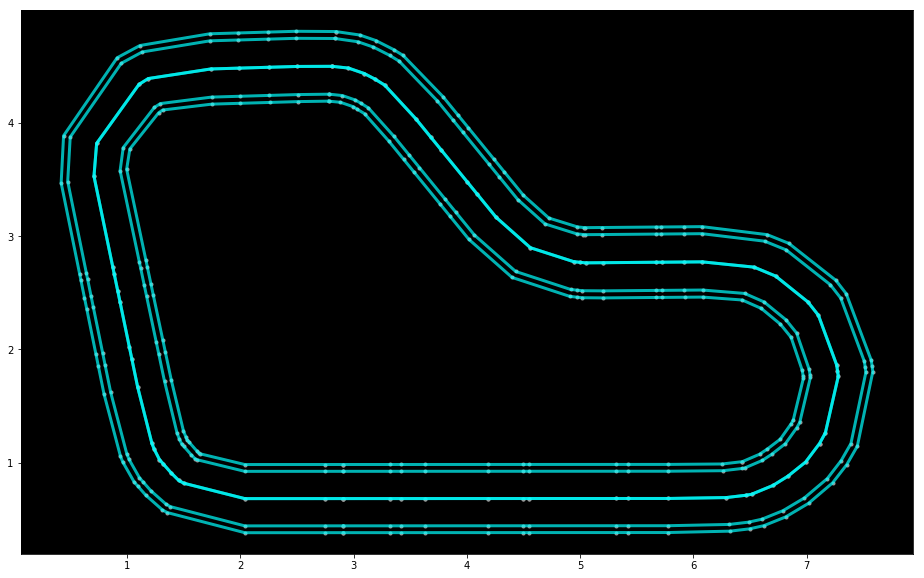

In [7]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
def plot_line_red(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
def plot_line_green(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

    
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

# Also print new border
print_border(ax, center_line, inner_border_new, outer_border_new)


In [8]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [9]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=8 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=10 # default 1000

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

## Get the race line!

In [10]:
# Path of the optimal racing line (.npy file)
fpath = "./reinvent_base-10000-8-2020-07-25-154703.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "reinvent_base"

race_line = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
race_line = race_line.tolist()[:-1]
print(race_line)

[[2.8940328208674604, 0.7018375906132979], [3.16466256169927, 0.6930018714283173], [3.4331368638317175, 0.6882311867125444], [3.7380483325340554, 0.685483091771756], [4.107486970319245, 0.6843830851442457], [4.4112052994946955, 0.6840270210890935], [4.708590974992255, 0.6838831451202598], [5.320002125723089, 0.6840540742077795], [5.472935615138013, 0.6883734333715799], [5.73669211581363, 0.7062112522184065], [5.991882986663751, 0.7439684578641856], [6.212495090412336, 0.8000855274846637], [6.4015872277833115, 0.8723047149720226], [6.564173957471189, 0.9594683198534688], [6.703374241580095, 1.0612243239052852], [6.820298554202562, 1.177731768885542], [6.914131135943836, 1.309411908636562], [6.981814890320411, 1.4565615197189885], [7.021747594398437, 1.6169472670674616], [7.028312574332178, 1.7883227175517744], [6.993936911216881, 1.9654970855507914], [6.9140612207498195, 2.1394798324545543], [6.7825250779774855, 2.296822620381092], [6.615502339836281, 2.4326489624641017], [6.42188674006

These should be the same:  ((71, 2), (71, 2))
Original centerline length: 17.67
New race line length: 16.19


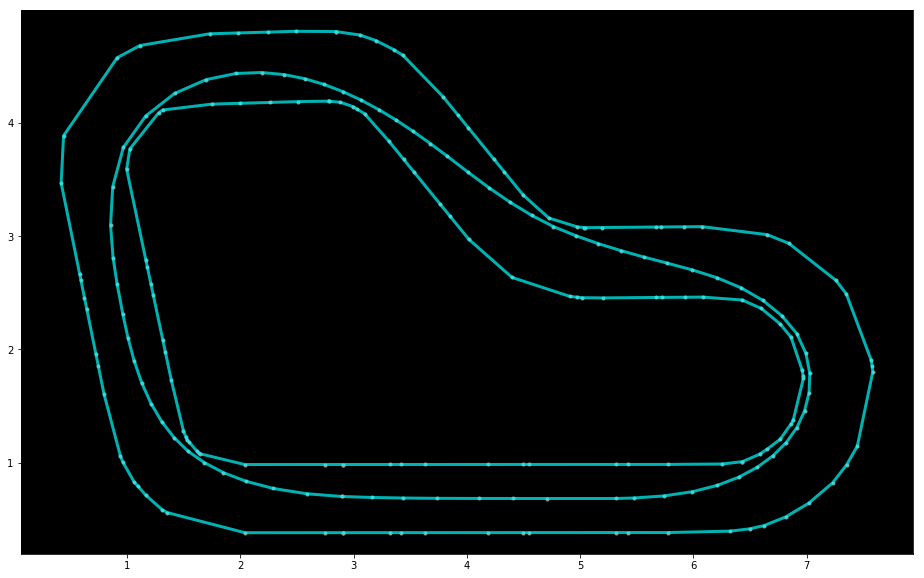

In [11]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

# Also print new border
#print_border(ax, loop_race_line, inner_border_new, outer_border_new)

# Load and visualize a stored track file

In [12]:


def load_data(fname):
    data = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "SIM_TRACE_LOG" in line:
                parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split(",")
                data.append(",".join(parts))
    return data

def convert_to_pandas(data, wpts=None):

    """
    stdout_ = 'SIM_TRACE_LOG:%d,%d,%.4f,%.4f,%.4f,%.2f,%.2f,%d,%.4f,%s,%s,%.4f,%d,%.2f,%s\n' % (
            self.episodes, self.steps, model_location[0], model_location[1], model_heading,
            self.steering_angle,
            self.speed,
            self.action_taken,
            self.reward,
            self.done,
            all_wheels_on_track,
            current_progress,
            closest_waypoint_index,
            self.track_length,
            time.time())
        print(stdout_)
    """        

    df_list = list()
    
    #ignore the first two dummy values that coach throws at the start.
    for d in data[2:]:
        parts = d.rstrip().split(",")
        episode = int(parts[0])
        steps = int(parts[1])
        x = float(parts[2])
        y = float(parts[3])
        ##cWp = get_closest_waypoint(x, y, wpts)
        yaw = float(parts[4])
        steer = float(parts[5])
        throttle = float(parts[6])
        action = float(parts[7])
        reward = float(parts[8])
        done = 0 if 'False' in parts[9] else 1
        all_wheels_on_track = parts[10]
        progress = float(parts[11])
        closest_waypoint = int(parts[12])
        track_len = float(parts[13])
        tstamp = parts[14]
        
        #desired_action = int(parts[10])
        #on_track = 0 if 'False' in parts[12] else 1
        
        df_list.append((episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress,
                        closest_waypoint, track_len, tstamp))

    header = ['episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint', 'track_len', 'timestamp']
    
    df = pd.DataFrame(df_list, columns=header)
    return df

In [13]:
def episode_parser(df, action_map=True, episode_map=True):
    '''
    Arrange data per episode
    '''
    action_map = {} # Action => [x,y,reward] 
    episode_map = {} # Episode number => [x,y,action,reward] 

    for index, row in df.iterrows():
        e = int(row['episode'])
        x = float(row['x']) 
        y = float(row['y'])
        angle = float(row['steer'])
        ttl = float(row['throttle'])
        action = int(row['action'])
        reward = float(row['reward'])

        try:
            episode_map[e]
        except KeyError:
            episode_map[e] = np.array([0,0,0,0,0,0]) #dummy
        episode_map[e] = np.vstack((episode_map[e], np.array([x,y,action,reward,angle,ttl])))

        try:
            action_map[action]
        except KeyError:
            action_map[action] = []
        action_map[action].append([x, y, reward])
                
    # top laps
    total_rewards = {}
    for x in episode_map.keys():
        arr = episode_map[x]
        total_rewards[x] = np.sum(arr[:,3])

    import operator
    top_idx = dict(sorted(total_rewards.items(), key=operator.itemgetter(1), reverse=True)[:])
    sorted_idx = list(top_idx.keys())

    return action_map, episode_map, sorted_idx


In [17]:
def getMainEpidode(episode_map1):
    maxlenEpisode=0
    maxLen=0
    for ii in range(len(episode_map1)):
        if maxLen<len(episode_map1[ii]):
            maxlenEpisode=ii
            maxLen=len(episode_map1[ii])
    return episode_map1[maxlenEpisode]
#print(getMainEpidode(episode_map1))


In [18]:
def GetMainEpisode(f1):
    data1=load_data(f1)
    df1=convert_to_pandas(data1)
    action_map1, episode_map1, sorted_idx1=episode_parser(df1)
    path1=episode_map1[2][1:,0:2].tolist()
    return path1

These should be the same:  ((71, 2), (71, 2))
Original centerline length: 17.67
New race line length: 16.19


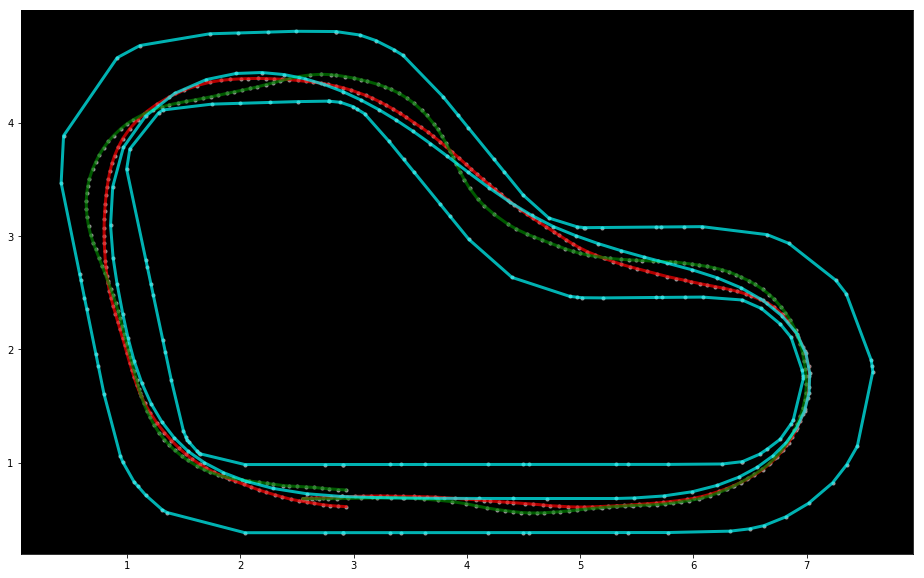

In [19]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)
# These should be the same
# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')

path1=GetMainEpisode(f1)
#loop_race_line = np.append(path1, [path1[0]], axis=0)

plot_coords(ax, LineString(path1))                                                       
plot_line_red(ax, LineString(path1))  


path2=GetMainEpisode(f2)
plot_coords(ax, LineString(path2))                                                       
plot_line_green(ax, LineString(path2))  

plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)